In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
hd_pct = 0.005

params = [
                    {
                    'filtered': True,
                    'fx_filtered': True,
                    'topn': 1,
                    'top_fx': 1,
                    'top_cx': 3,
                    'only_fx': False,
                    'enbale_industry': False,
                    'empty_priority': False
                    },
                    {
                    'filtered': True,
                    'fx_filtered': True,
                    'topn': 1,
                    'top_fx': 2,
                    'top_cx': 2,
                    'only_fx': True,
                    'enbale_industry': False,
                    'empty_priority': False
                    },
                    {
                    'filtered': True,
                    'fx_filtered': True,
                    'topn': 1,
                    'top_fx': 4,
                    'top_cx': 3,
                    'only_fx': False,
                    'enbale_industry': True,
                    'empty_priority': False
                    }
            ]

In [4]:
def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [5]:
def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


In [ ]:
param0 = params[1]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [ ]:
import sqlite3
# months = ['202502']
# months = ['202409', '202410', '202411', '202412', '202501', '202502' ]
months = ['202411', '202412']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '中位低吸') and stock_rank < 3 " % db_name
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,149,2024-11-01,低吸,中位低吸,002406.XSHE,远东传动,1,"000026.BKDL,000006.BKDL,000027.BKDL,000013.BKD...","885743.DDBK,885806.DDBK,885517.DDBK,885783.DDB...",980372.ZHBK,...,中位低吸,118.54,-1.62,13,161.16,-4.57,6,"{""9A0001"": {""realShortLineScore"": 33.68, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-02-15 18:23:35
1,150,2024-11-01,低吸,中位低吸,603958.XSHG,哈森股份,2,,,,...,中位低吸,118.54,-1.62,13,161.16,-4.57,6,"{""9A0001"": {""realShortLineScore"": 33.68, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-02-15 18:23:35
2,247,2024-11-04,低吸,中位低吸,603991.XSHG,至正股份,1,"000036.BKDL,000035.BKDL,000023.BKDL,000006.BKD...","885571.DDBK,885739.DDBK,885806.DDBK,886009.DDB...",980364.ZHBK,...,中位低吸,50.82,-67.72,17,130.84,-23.14,7,"{""9A0001"": {""realShortLineScore"": 23.79, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 18:25:10
3,248,2024-11-04,低吸,中位低吸,600246.XSHG,万通发展,2,"000031.BKDL,000037.BKDL,000004.BKDL,000025.BKDL","885520.DDBK,886033.DDBK,885514.DDBK,885574.DDB...",980358.ZHBK,...,中位低吸,50.82,-67.72,17,130.84,-23.14,7,"{""9A0001"": {""realShortLineScore"": 23.79, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 18:25:10
4,344,2024-11-05,低吸,中位低吸,002272.XSHE,川润股份,1,"000035.BKDL,000023.BKDL,000011.BKDL,000006.BKD...","885571.DDBK,885996.DDBK,885425.DDBK,885854.DDB...","980365.ZHBK,980474.ZHBK",...,中位低吸,105.40,54.58,8,152.17,2.73,5,"{""9A0001"": {""realShortLineScore"": 59.95, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 18:26:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,1765,2024-12-27,低吸,中位低吸,002660.XSHE,茂硕电源,2,"000012.BKDL,000003.BKDL,000008.BKDL,000026.BKD...","885840.DDBK,885936.DDBK,885739.DDBK,886021.DDB...",980357.ZHBK,...,中位低吸,-66.26,10.85,48,7.62,-8.84,20,"{""9A0001"": {""realShortLineScore"": -29.92, ""rea...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 19:17:01
82,1835,2024-12-30,低吸,中位低吸,002137.XSHE,实益达,1,"000012.BKDL,000008.BKDL,000026.BKDL,000023.BKD...","885785.DDBK,885840.DDBK,885757.DDBK,886009.DDB...","980357.ZHBK,980355.ZHBK",...,中位低吸,-60.74,5.52,46,-9.14,-15.60,21,"{""9A0001"": {""realShortLineScore"": -10.83, ""rea...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 19:18:15
83,1836,2024-12-30,低吸,中位低吸,605066.XSHG,天正电气,2,"000023.BKDL,000035.BKDL,000011.BKDL,000007.BKD...","885869.DDBK,885783.DDBK,885921.DDBK,885919.DDB...",980474.ZHBK,...,中位低吸,-60.74,5.52,46,-9.14,-15.60,21,"{""9A0001"": {""realShortLineScore"": -10.83, ""rea...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 19:18:15
84,1904,2024-12-31,低吸,中位低吸,002577.XSHE,雷柏科技,1,"000012.BKDL,000026.BKDL,000014.BKDL,000010.BKD...","885517.DDBK,885774.DDBK,885603.DDBK,885420.DDB...",980366.ZHBK,...,中位低吸,-78.32,-17.58,56,-19.15,-7.29,27,"{""9A0001"": {""realShortLineScore"": -45.43, ""rea...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-02-15 19:19:25


In [8]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']
combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27140\1079973233.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,
2024-11-01,150,低吸,中位低吸,603958.XSHG,哈森股份,2,,,,-1,...,-1.62,13,161.16,-4.57,6,2025-02-15 18:23:35,-0.137241,-0.142241,-0.093103,-0.098103
2024-11-04,247,低吸,中位低吸,603991.XSHG,至正股份,1,"000036.BKDL,000035.BKDL,000023.BKDL,000006.BKD...","885571.DDBK,885739.DDBK,885806.DDBK,886009.DDB...",980364.ZHBK,3,...,-67.72,17,130.84,-23.14,7,2025-02-15 18:25:10,0.004554,-0.000446,0.013663,0.008663
2024-11-05,344,低吸,中位低吸,002272.XSHE,川润股份,1,"000035.BKDL,000023.BKDL,000011.BKDL,000006.BKD...","885571.DDBK,885996.DDBK,885425.DDBK,885854.DDB...","980365.ZHBK,980474.ZHBK",2,...,54.58,8,152.17,2.73,5,2025-02-15 18:26:34,0.025514,0.020514,-0.019753,-0.024753
2024-11-06,439,低吸,中位低吸,603887.XSHG,城地香江,1,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885887.DDBK,885806.DDBK,885957.DDBK,885362.DDB...","980338.ZHBK,980753.ZHBK,980366.ZHBK",4,...,5.90,4,158.50,-3.50,3,2025-02-15 18:27:58,-0.016756,-0.021756,-0.046247,-0.051247
2024-11-07,529,低吸,中位低吸,600318.XSHG,新力金融,1,"000023.BKDL,000010.BKDL,000015.BKDL","885740.DDBK,886016.DDBK,885456.DDBK","980360.ZHBK,980341.ZHBK",9,...,-18.53,7,151.31,-8.79,2,2025-02-15 18:29:23,0.097909,0.092909,0.043726,0.038726
2024-11-08,608,低吸,中位低吸,002312.XSHE,川发龙蟒,1,"000003.BKDL,000038.BKDL,000024.BKDL,000035.BKD...","885694.DDBK,886021.DDBK,885710.DDBK,885863.DDB...","980366.ZHBK,980364.ZHBK",1,...,29.48,2,163.72,1.68,3,2025-02-15 18:30:45,-0.004202,-0.009202,-0.008403,-0.013403
2024-11-11,713,低吸,中位低吸,600513.XSHG,联环药业,1,"000010.BKDL,000009.BKDL,000017.BKDL","885420.DDBK,886021.DDBK,886015.DDBK,885879.DDB...",980378.ZHBK,3,...,-10.08,5,158.36,-5.26,2,2025-02-15 18:32:17,-0.015831,-0.020831,-0.023747,-0.028747
2024-11-12,822,低吸,中位低吸,002178.XSHE,延华智能,1,"000012.BKDL,000003.BKDL,000008.BKDL,000011.BKD...","885993.DDBK,885517.DDBK,885522.DDBK,885919.DDB...","980338.ZHBK,980366.ZHBK,980343.ZHBK",1,...,-18.64,7,152.46,-8.54,2,2025-02-15 18:33:51,0.001255,-0.003745,-0.025094,-0.030094
2024-11-13,909,低吸,中位低吸,002765.XSHE,蓝黛科技,2,"000012.BKDL,000038.BKDL,000006.BKDL,000027.BKD...","885694.DDBK,885834.DDBK,885709.DDBK,886008.DDB...","980372.ZHBK,980357.ZHBK",1,...,-7.08,8,145.57,-3.51,2,2025-02-15 18:35:12,-0.051921,-0.056921,-0.089304,-0.094304


In [9]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    df = pd.DataFrame()
    for key in all_data.keys():
        ndf = all_data[key].T
        ndf = ndf.sort_index()
        ndf.columns = [key]
        df = pd.concat([df, ndf], axis=1)
    
    i = 1
    for idx, rrow in df[1:11].iterrows():
        combined_df.loc[date_key, f'close_{i}'] = rrow['close']
        combined_df.loc[date_key, f'low_{i}'] = rrow['low']
        i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



C:\Users\Administrator\AppData\Local\Temp\ipykernel_27140\498375655.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.41' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'close_{i}'] = rrow['close']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27140\498375655.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.38' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'low_{i}'] = rrow['low']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27140\498375655.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype f

In [10]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-11-01,14.50,13.15,14.38,14.00,14.05,13.99,14.01,14.04,13.90,13.90,13.90,13.91
2024-11-04,76.85,77.90,78.48,78.91,78.93,79.00,78.20,79.16,80.10,79.90,80.16,80.50
2024-11-05,12.15,11.91,12.39,12.21,12.28,12.45,12.27,12.26,12.38,12.40,12.30,12.31
2024-11-06,14.92,14.23,14.99,15.07,14.98,14.93,14.97,14.95,14.69,14.64,14.78,14.76
2024-11-07,10.52,10.98,10.60,10.69,10.98,10.97,11.40,11.30,11.26,11.38,11.53,11.48
2024-11-08,16.66,16.52,16.80,16.68,16.67,16.66,16.66,16.66,16.66,16.66,16.66,16.66
2024-11-11,11.37,11.10,11.68,11.79,11.63,11.54,11.57,11.46,11.50,11.53,11.55,11.58
2024-11-12,7.97,7.77,8.00,8.01,8.09,8.05,8.09,8.13,8.20,8.18,8.19,8.16
2024-11-13,9.63,8.77,9.39,9.31,9.38,9.51,9.51,9.55,9.56,9.38,9.44,9.41


In [11]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
dwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,
2024-11-01,150,低吸,中位低吸,603958.XSHG,哈森股份,2,,,,-1,...,14.04,13.90,13.90,13.90,13.90,14.11,13.90,13.92,13.91,14.88
2024-11-04,247,低吸,中位低吸,603991.XSHG,至正股份,1,"000036.BKDL,000035.BKDL,000023.BKDL,000006.BKD...","885571.DDBK,885739.DDBK,885806.DDBK,886009.DDB...",980364.ZHBK,3,...,79.16,80.43,80.10,81.00,79.90,80.23,80.16,81.50,80.50,78.48
2024-11-05,344,低吸,中位低吸,002272.XSHE,川润股份,1,"000035.BKDL,000023.BKDL,000011.BKDL,000006.BKD...","885571.DDBK,885996.DDBK,885425.DDBK,885854.DDB...","980365.ZHBK,980474.ZHBK",2,...,12.26,12.54,12.38,12.40,12.40,12.32,12.30,12.40,12.31,12.42
2024-11-06,439,低吸,中位低吸,603887.XSHG,城地香江,1,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885887.DDBK,885806.DDBK,885957.DDBK,885362.DDB...","980338.ZHBK,980753.ZHBK,980366.ZHBK",4,...,14.95,14.69,14.69,14.88,14.64,14.78,14.78,14.89,14.76,15.10
2024-11-07,529,低吸,中位低吸,600318.XSHG,新力金融,1,"000023.BKDL,000010.BKDL,000015.BKDL","885740.DDBK,886016.DDBK,885456.DDBK","980360.ZHBK,980341.ZHBK",9,...,11.30,11.58,11.26,11.47,11.38,11.65,11.53,11.63,11.48,10.60
2024-11-08,608,低吸,中位低吸,002312.XSHE,川发龙蟒,1,"000003.BKDL,000038.BKDL,000024.BKDL,000035.BKD...","885694.DDBK,886021.DDBK,885710.DDBK,885863.DDB...","980366.ZHBK,980364.ZHBK",1,...,16.66,16.66,16.66,16.66,16.66,16.66,16.66,16.66,16.66,16.80
2024-11-11,713,低吸,中位低吸,600513.XSHG,联环药业,1,"000010.BKDL,000009.BKDL,000017.BKDL","885420.DDBK,886021.DDBK,886015.DDBK,885879.DDB...",980378.ZHBK,3,...,11.46,11.60,11.50,11.57,11.53,11.58,11.55,11.66,11.58,11.68
2024-11-12,822,低吸,中位低吸,002178.XSHE,延华智能,1,"000012.BKDL,000003.BKDL,000008.BKDL,000011.BKD...","885993.DDBK,885517.DDBK,885522.DDBK,885919.DDB...","980338.ZHBK,980366.ZHBK,980343.ZHBK",1,...,8.13,8.29,8.20,8.19,8.18,8.19,8.19,8.16,8.16,8.00
2024-11-13,909,低吸,中位低吸,002765.XSHE,蓝黛科技,2,"000012.BKDL,000038.BKDL,000006.BKDL,000027.BKD...","885694.DDBK,885834.DDBK,885709.DDBK,886008.DDB...","980372.ZHBK,980357.ZHBK",1,...,9.55,9.58,9.56,9.41,9.38,9.54,9.44,9.44,9.41,9.64


In [12]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [15]:

dwndx['r_return'] = dwndx['next_day_close_price']/dwndx['real_open'] - 1
dwndx['r_return'] = dwndx['r_return']-0.001
dwndx['cumulative_returns'] = (1 + dwndx['r_return']).cumprod()
print("return:")
caculate_returns(dwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -77.68%
夏普比率: -0.45
总收益率: -80.30%
年化收益率: -448.19%
波动率: 7.68%
总盈亏: -68.57%
成功次数: 12
失败次数: 31
总天数: 43
总交易次数: 43
交易频率: 100.00%
胜率: 27.91%
平均盈利: 5.75%
平均亏损: -6.98%
最大盈利: 26.73%
最大亏损: -15.19%
盈亏比: 0.82
凯利公式最佳仓位: -59.59%
-----------------------------------------------------


In [14]:
# dwndx['real_return'] = dwndx['return']-0.005
# dwndx['cumulative_returns'] = (1 + dwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(dwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

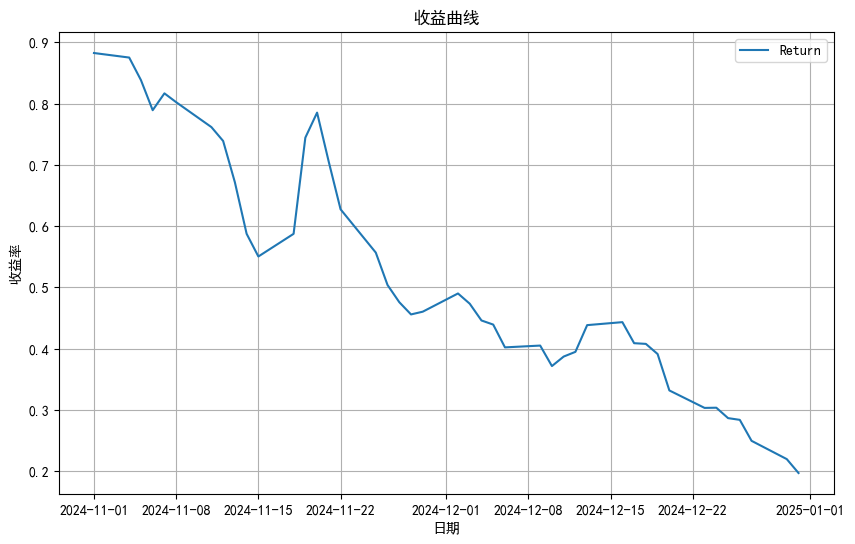

In [16]:
plot(dwndx, 'cumulative_returns')

In [16]:
dwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,
2024-11-01,153,低吸,中位低吸,000727.XSHE,冠捷科技,5,"000012.BKDL,000026.BKDL,000023.BKDL,000018.BKD...","885875.DDBK,885595.DDBK,885545.DDBK,885953.DDB...",980357.ZHBK,1,...,3.11,3.12,3.12,3.03,3.03,3.08,3.01,2.88,-0.018361,0.981639
2024-11-04,250,低吸,中位低吸,002178.XSHE,延华智能,4,"000012.BKDL,000003.BKDL,000008.BKDL,000011.BKD...","885993.DDBK,885517.DDBK,885522.DDBK,885919.DDB...","980338.ZHBK,980366.ZHBK,980343.ZHBK",1,...,6.15,6.31,6.19,6.23,6.23,6.43,6.23,6.08,0.314789,1.290648
2024-11-05,347,低吸,中位低吸,600178.XSHG,东安动力,4,"000027.BKDL,000004.BKDL,000017.BKDL,000033.BKDL","886021.DDBK,885595.DDBK,886008.DDBK,886061.DDB...",980372.ZHBK,1,...,14.47,14.52,14.52,14.55,14.52,14.75,14.48,13.80,0.132333,1.461444
2024-11-06,439,低吸,中位低吸,603887.XSHG,城地香江,1,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885887.DDBK,885806.DDBK,885957.DDBK,885362.DDB...","980338.ZHBK,980753.ZHBK,980366.ZHBK",4,...,14.69,14.88,14.64,14.78,14.78,14.89,14.76,15.10,-0.058616,1.375780
2024-11-07,529,低吸,中位低吸,600318.XSHG,新力金融,1,"000023.BKDL,000010.BKDL,000015.BKDL","885740.DDBK,886016.DDBK,885456.DDBK","980360.ZHBK,980341.ZHBK",9,...,11.26,11.47,11.38,11.65,11.53,11.63,11.48,10.60,0.034849,1.423725
2024-11-08,608,低吸,中位低吸,002312.XSHE,川发龙蟒,1,"000003.BKDL,000038.BKDL,000024.BKDL,000035.BKD...","885694.DDBK,886021.DDBK,885710.DDBK,885863.DDB...","980366.ZHBK,980364.ZHBK",1,...,16.66,16.66,16.66,16.66,16.66,16.66,16.66,16.80,-0.017667,1.398573
2024-11-11,718,低吸,中位低吸,002418.XSHE,康盛股份,6,,,,-1,...,2.85,2.87,2.85,2.84,2.84,2.83,2.82,2.78,-0.036971,1.346866
2024-11-12,822,低吸,中位低吸,002178.XSHE,延华智能,1,"000012.BKDL,000003.BKDL,000008.BKDL,000011.BKD...","885993.DDBK,885517.DDBK,885522.DDBK,885919.DDB...","980338.ZHBK,980366.ZHBK,980343.ZHBK",1,...,8.20,8.19,8.18,8.19,8.19,8.16,8.16,8.00,-0.029750,1.306796
2024-11-13,909,低吸,中位低吸,002765.XSHE,蓝黛科技,2,"000012.BKDL,000038.BKDL,000006.BKDL,000027.BKD...","885694.DDBK,885834.DDBK,885709.DDBK,886008.DDB...","980372.ZHBK,980357.ZHBK",1,...,9.56,9.41,9.38,9.54,9.44,9.44,9.41,9.64,-0.091249,1.187553
